In [9]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import ase

In [10]:
pos_traj_path = "/home/kristjan/sshfs/hypatia_project/md_autocorr/run-NH2O-MD-T300.xyz"
vel_traj_path = "/home/kristjan/sshfs/hypatia_project/md_autocorr/run-NH2O-MD-T300-vel-1.xyz"

at_pos_list = ase.io.read(pos_traj_path, index=':')
at_vel_list = ase.io.read(vel_traj_path, index=':')

# Units:
# velocities in [bohr/au_time] = (0.529177 ang)/(0.0242 fs)
# positions in [ang]

In [58]:

n_window = 50
start_point_spacing = 10

at_per_mol = 3

n_timesteps = len(at_vel_list)
n_mols = int(len(at_vel_list[0])/at_per_mol)

if len(at_vel_list[0]) % at_per_mol != 0:
    print("Error: number of atoms needs to divide 3 (number of atoms in the molecule).")

autocorr_histogram = [[] for i in range(n_window)]
starting_point_vels = []

for i_time, at_vel in enumerate(at_vel_list):
    
    # Calculate the velocities of the mass centers of each molecule
    vel_mols = np.zeros((n_mols, 3))
    for i in range(n_mols):
        vel_atoms = at_vel.positions[at_per_mol*i:at_per_mol*(i+1)]
        at_masses = at_vel.get_masses()[at_per_mol*i:at_per_mol*(i+1)]
        for i_at in range(at_per_mol):
            vel_mols[i, :] += at_masses[i_at]*vel_atoms[i_at, :]
        vel_mols[i, :] /= np.sum(at_masses)
        
    # Convert velocities to ang/fs
    vel_mols *= 0.529177/0.0242
    
    if i_time % start_point_spacing == 0:
        starting_point_vels.append(np.copy(vel_mols))
    
    for i_sp in range(len(starting_point_vels)-1, -1, -1):
        index_delta = i_time - i_sp*start_point_spacing
        if index_delta >= n_window:
            break
        autocorr_histogram[index_delta].append(np.mean(np.sum(starting_point_vels[i_sp]*vel_mols, axis=1)))

        
# average over the histograms
# and also calculate the diffusion coeff
dt = 10.0 # fs
autocorr = np.zeros(n_window)
diffusion_coef = np.zeros(n_window)
for i in range(n_window):
    autocorr[i] = np.mean(autocorr_histogram[i])
    diffusion_coef[i] = diffusion_coef[i-1] + 1/3*autocorr[i]*dt


In [59]:
diffusion_coef

array([ 0.00013799,  0.00026679,  0.00037366,  0.00045432,  0.00051037,
        0.00054628,  0.00056787,  0.00058084,  0.00059024,  0.00059948,
        0.00061045,  0.00062292,  0.00063548,  0.00064712,  0.00065715,
        0.00066461,  0.0006689 ,  0.00067037,  0.00066958,  0.00066705,
        0.00066284,  0.00065743,  0.00065131,  0.00064492,  0.00063836,
        0.00063135,  0.0006237 ,  0.00061574,  0.0006079 ,  0.0006004 ,
        0.0005936 ,  0.00058798,  0.00058292,  0.00057781,  0.0005726 ,
        0.00056758,  0.00056249,  0.00055719,  0.00055162,  0.0005455 ,
        0.0005384 ,  0.00053072,  0.00052336,  0.00051666,  0.0005107 ,
        0.00050551,  0.00050139,  0.00049863,  0.00049688,  0.00049563])

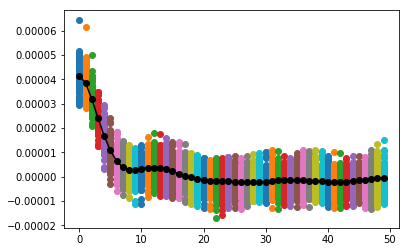

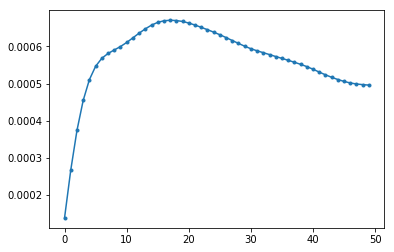

In [33]:
for i_col, hist_column in enumerate(autocorr_histogram):
    plt.plot([i_col]*len(hist_column), hist_column, 'o')

plt.plot(autocorr, 'ko-')
plt.savefig("./fig/velocity_autocorr.png", dpi=200)
plt.show()

plt.plot(diffusion_coef, '.-')
plt.savefig("./fig/diffusion_coef.png", dpi=200)
plt.show()

# Mean-square displacement

In [29]:

n_window = 50
start_point_spacing = 10

n_timesteps = len(at_pos_list)
n_mols = int(len(at_pos_list[0])/3)

if len(at_pos_list[0]) % 3 != 0:
    print("Error: number of atoms needs to divide 3 (number of atoms in the molecule).")

histogram = [[] for i in range(n_window)]
starting_point_pos = []

for i_time, at_pos in enumerate(at_pos_list):
    
    # Calculate the positions of the mass centers of each molecule
    # Assuming that the order of each molecule is O-H-H O-H-H, ...
    pos_mols = np.zeros((n_mols, 3))
    for i in range(n_mols):
        pos_ohh = at_pos.positions[3*i:3*(i+1)]
        pos_mols[i, :] = (16*pos_ohh[0, :] + pos_ohh[1, :] + pos_ohh[2, :])/18
    
    if i_time % start_point_spacing == 0:
        starting_point_pos.append(np.copy(pos_mols))
    
    for i_sp in range(len(starting_point_pos)-1, -1, -1):
        index_delta = i_time - i_sp*start_point_spacing
        if index_delta >= n_window:
            break
        histogram[index_delta].append(np.mean(np.sum((starting_point_pos[i_sp]-pos_mols)**2, axis=1)))

        
# average over the histograms
msd = np.zeros(n_window)
for i in range(n_window):
    msd[i] = np.mean(histogram[i])

# Time array
dt = 10.0 # fs
t_arr = np.arange(0, n_window, 1)*dt

# Fit a straight line that goes through (0.0)
slope = np.linalg.lstsq(t_arr.reshape(-1, 1), msd)[0][0]
print("Diffusion coef:", slope/(2*3))

Diffusion coef: 0.00050257869023


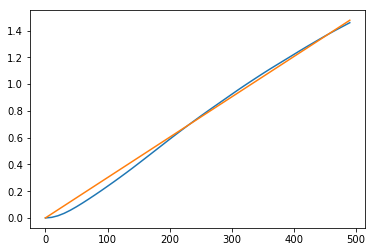

In [30]:
plt.plot(t_arr, msd)
plt.plot(t_arr, t_arr*slope)
plt.savefig("./fig/msd.png", dpi=200)
plt.show()
plt.show()